This kernel is adapted from @willkoehrsen kaggle kernel

## Feature Selection :

Feature selection, the process of finding and selecting the most useful features in a dataset, is a crucial step of the machine learning pipeline. Unnecessary features decrease training speed, decrease model interpretability, and, most importantly, decrease generalization performance on the test set.

The techniques discussed in this kernel are below

1. Features with a high percentage of missing values 
2. Collinear (highly correlated) features 
3. Features with zero importance in a tree-based model 


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder

%matplotlib inline

In [2]:
# loading dataset 
training_v2 = pd.read_csv("../input/widsdatathon2020/training_v2.csv")


In [3]:
# creating independent features X and dependant feature Y
y = training_v2['hospital_death']
X = training_v2.copy()
X = training_v2.drop('hospital_death',axis = 1)
X1 = training_v2.drop('hospital_death',axis = 1)


## Collinear (highly correlated) features  

Collinear features are features that are highly correlated with one another. In machine learning, these lead to decreased generalization performance on the test set due to high variance and less model interpretability.

In [4]:
# Threshold for removing correlated variables
threshold = 0.9

# Absolute value correlation matrix
corr_matrix = X.corr().abs()
corr_matrix.head()

,encounter_id,patient_id,hospital_id,age,bmi,elective_surgery,height,icu_id,pre_icu_los_days,readmission_status,...,apache_4a_hospital_death_prob,apache_4a_icu_death_prob,aids,cirrhosis,diabetes_mellitus,hepatic_failure,immunosuppression,leukemia,lymphoma,solid_tumor_with_metastasis
encounter_id,1.000000,0.009575,0.004532,0.003990,0.001068,0.002036,0.005400,0.000992,0.000570,NaN,...,0.000513,0.000344,0.001907,0.007601,0.003402,0.000972,0.001707,0.002172,0.001176,0.004646
patient_id,0.009575,1.000000,0.007075,0.006343,0.001380,0.001387,0.002902,0.001770,0.004412,NaN,...,0.003735,0.001625,0.002426,0.001307,0.000434,0.001667,0.000548,0.000844,0.002333,0.003065
hospital_id,0.004532,0.007075,1.000000,0.008673,0.012874,0.052123,0.027895,0.004526,0.001285,NaN,...,0.006993,0.000283,0.004947,0.002962,0.011978,0.001362,0.000146,0.002992,0.002588,0.004730
age,0.003990,0.006343,0.008673,1.000000,0.087077,0.067320,0.109937,0.024257,0.049872,NaN,...,0.143167,0.076275,0.029477,0.028065,0.077908,0.020061,0.025007,0.030310,0.023335,0.025924
bmi,0.001068,0.001380,0.012874,0.087077,1.000000,0.015921,0.056316,0.001403,0.001531,NaN,...,0.033546,0.013796,0.020434,0.002377,0.172943,0.001855,0.031144,0.013375,0.010017,0.043380


In [5]:
# Upper triangle of correlations
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
upper.head()
# Select columns with correlations above threshold
to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
print('There are %d columns to remove.' % (len(to_drop)))
#Drop the columns with high correlations
X = X.drop(columns = to_drop)


There are 59 columns to remove.


## Features with a high percentage of missing values 

This method is used for finding features to remove features with more than 75% missing values


In [6]:
# Train missing values (in percent)
train_missing = (X.isnull().sum() / len(X)).sort_values(ascending = False)
train_missing.head()
train_missing = train_missing.index[train_missing > 0.75]
print('There are %d columns with more than 75%% missing values' % len(train_missing))
X = X.drop(columns = train_missing)

There are 18 columns with more than 75% missing values


In [7]:
#Convert categorical variable into dummy/indicator variables.
X = pd.get_dummies(X)


## Features with zero importance in a tree-based model 

This is a non-deterministic function which finds features that have zero importance according to a gradient boosting machine (GBM) learning model.

In [8]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(X.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(objective='binary', boosting_type = 'goss', n_estimators = 10000, class_weight = 'balanced')

In [9]:
for i in range(2):
    
    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(X, y, test_size = 0.25, random_state = i)
    
    # Train using early stopping
    model.fit(train_features, train_y, early_stopping_rounds=100, eval_set = [(valid_features, valid_y)],eval_metric = 'auc', verbose = 200)
    
    # Record the feature importances
    feature_importances += model.feature_importances_

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's auc: 0.899281	valid_0's binary_logloss: 0.339973
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's auc: 0.895852	valid_0's binary_logloss: 0.360766


In [10]:
# Make sure to average feature importances! 
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame({'feature': list(X.columns), 'importance': feature_importances}).sort_values('importance', ascending = False)
feature_importances.head()

,feature,importance
90,apache_4a_hospital_death_prob,108.5
3,age,82.0
76,d1_lactate_min,79.0
38,d1_heartrate_min,67.0
7,icu_id,57.0


In [11]:
# Find the features with zero importance
zero_features = list(feature_importances[feature_importances['importance'] == 0.0]['feature'])
print('There are %d features with 0.0 importance' % len(zero_features))
feature_importances.tail()
# Drop features with zero importance
X = X.drop(columns = zero_features)

There are 34 features with 0.0 importance


In [12]:
def plot_feature_importances(df, threshold = 0.9):
    """
    Plots 15 most important features and the cumulative importance of features.
    Prints the number of features needed to reach threshold cumulative importance.
    
    Parameters
    --------
    df : dataframe
        Dataframe of feature importances. Columns must be feature and importance
    threshold : float, default = 0.9
        Threshold for prining information about cumulative importances
        
    Return
    --------
    df : dataframe
        Dataframe ordered by feature importances with a normalized column (sums to 1)
        and a cumulative importance column
    
    """
    
    plt.rcParams['font.size'] = 18
    
    # Sort features according to importance
    df = df.sort_values('importance', ascending = False).reset_index()
    
    # Normalize the feature importances to add up to one
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])

    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = (10, 6))
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:15]))), 
            df['importance_normalized'].head(15), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:15]))))
    ax.set_yticklabels(df['feature'].head(15))
    
    # Plot labeling
    plt.xlabel('Normalized Importance'); plt.title('Feature Importances')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumulative_importance'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Importance'); 
    plt.title('Cumulative Feature Importance');
    plt.show();
    
    importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
    print('%d features required for %0.2f of cumulative importance' % (importance_index + 1, threshold))
    
    return df

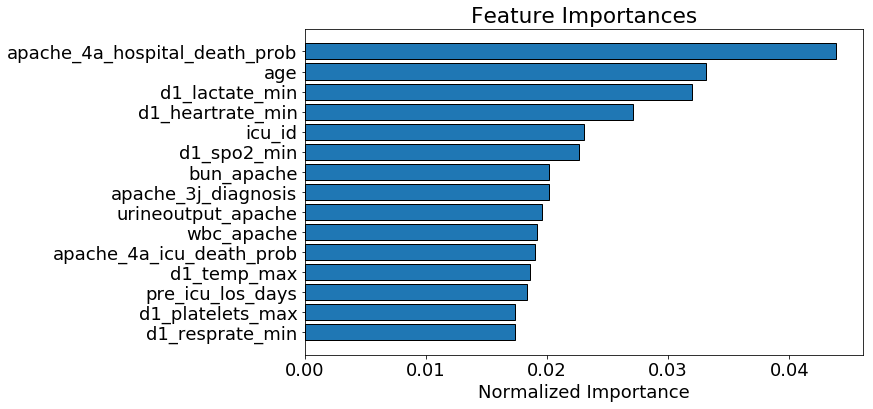

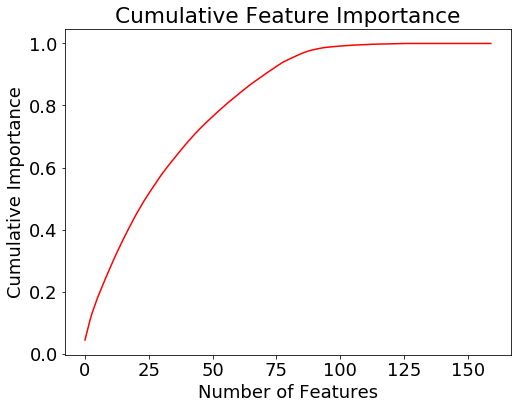

72 features required for 0.90 of cumulative importance


In [13]:
norm_feature_importances = plot_feature_importances(feature_importances)
